In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy.io as sio
import librosa

import time

import skimage
import skimage.io
from skimage.transform import rescale

from scipy.io import wavfile
import os
import subprocess

import sys
sys.path.append("../../src")
from spectrogramtools import *
from stego import *
from swpowerstego import *
from trimesh import *
from curvature import *

perfect matching with 2000 nodes and 3000 edges
    starting init...done [0.000 secs]. 32 trees
    .24.16.8.6.4.2.0.
done [0.001 secs]. 3944 grows, 0 expands, 0 shrinks
    expands: [0.000 secs], shrinks: [0.000 secs], dual updates: [0.000 secs]
cost = 1000.0


(-0.22086254308300712,
 0.2173325968963471,
 -0.8159462154897918,
 0.7184591352516316)

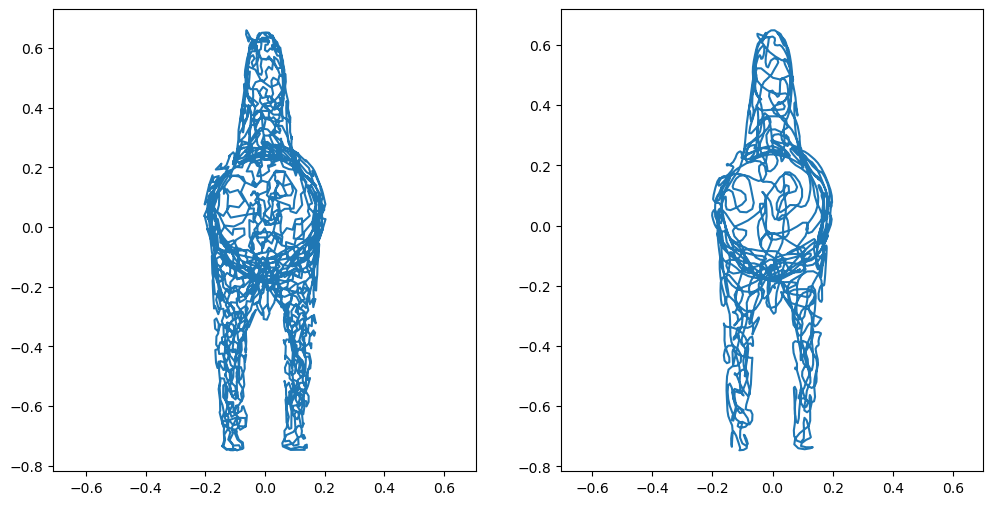

In [2]:
VPos, _, ITris = load_off("../../data/meshseg/396.off")
X = get_hamiltonian_cycle(VPos, ITris, blossom_path="../../blossom5")
X = X[:, [2, 1, 0]]

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(X[:, 0], X[:, 1])
plt.axis("equal")


s = get_arclen(get_curv_vectors(X, 0, 1, loop=True)[1])
X = arclen_resample(X, s, X.shape[0])
sigma = 1
X = get_curv_vectors(X, 0, sigma, loop=True)[0]
plt.subplot(122)
plt.plot(X[:, 0], X[:, 1])
plt.axis("equal")

## Load in audio and compute best target

[43, 86, 129]
Doing Gaps: win_length 1024, LT 64
viterbi_K =  3
Computing target coordinate 1 of 3...

Elapsed time: 2.712
Computing target coordinate 2 of 3...

Elapsed time: 1.177
Computing target coordinate 3 of 3...

Elapsed time: 1.606


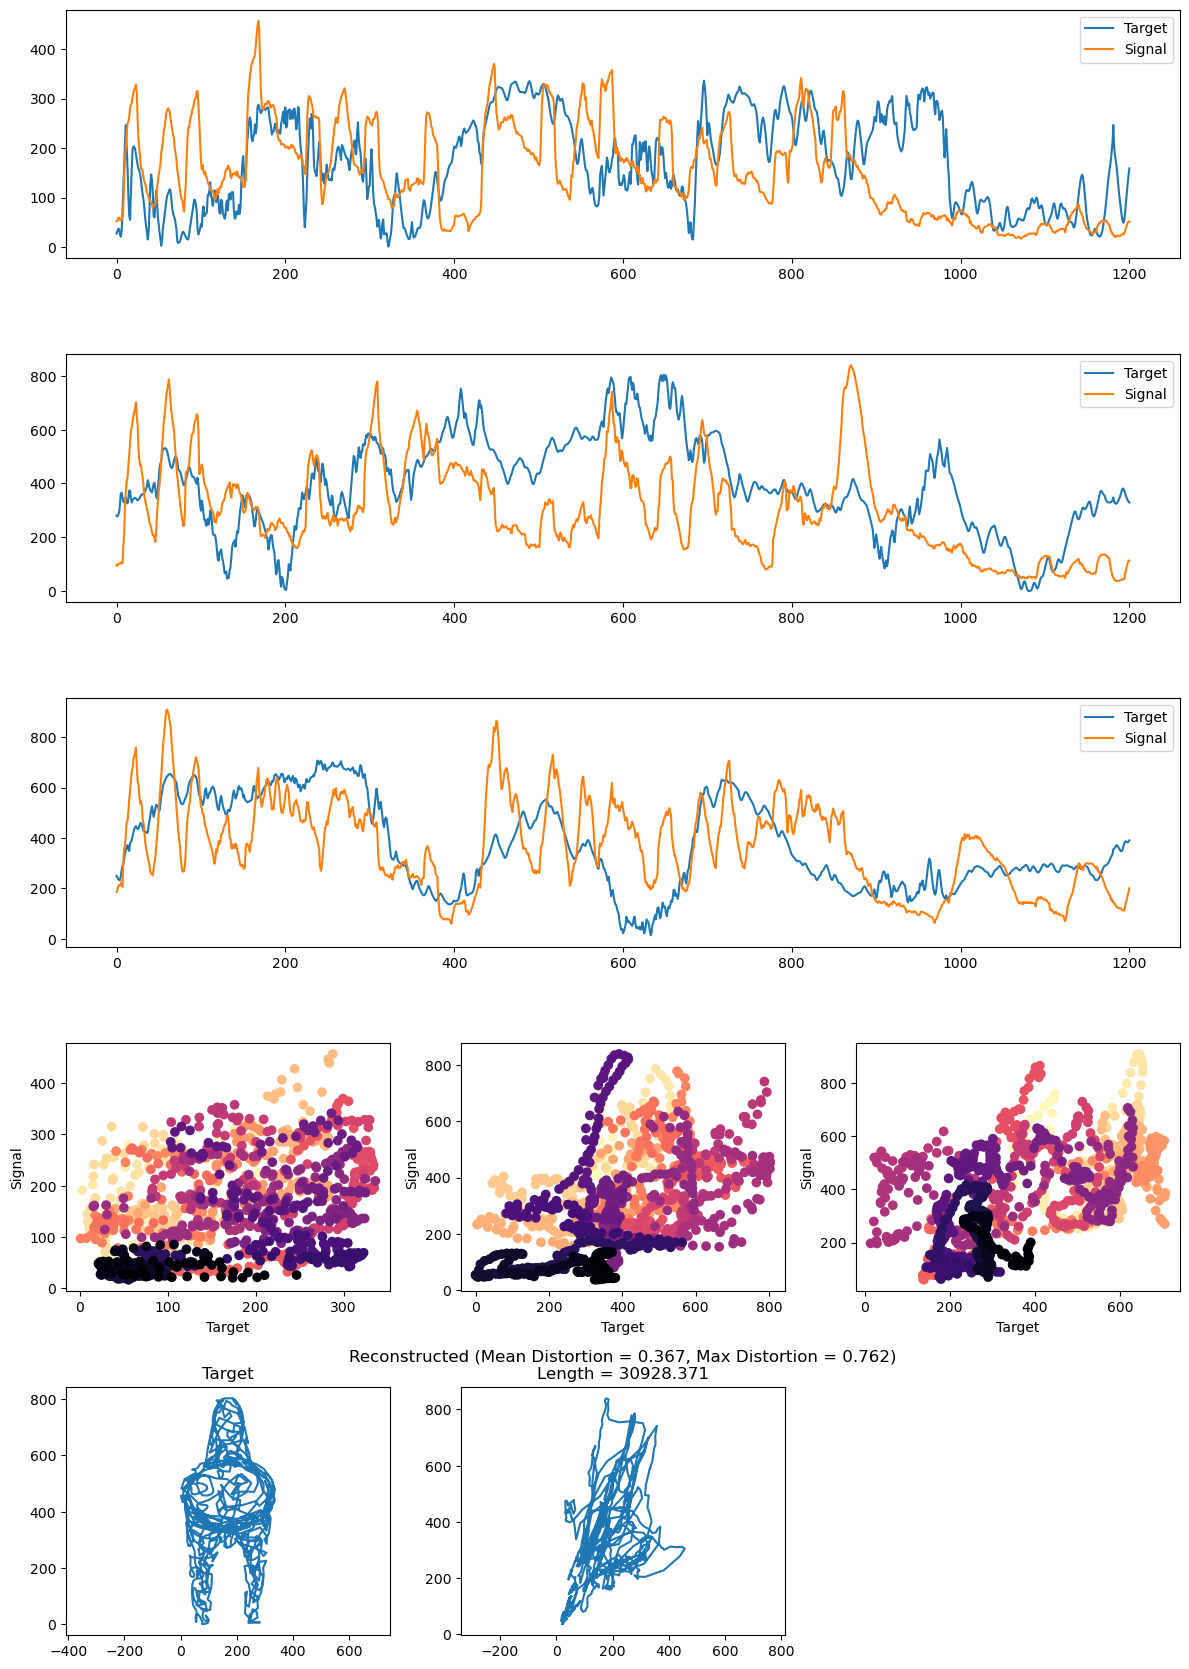

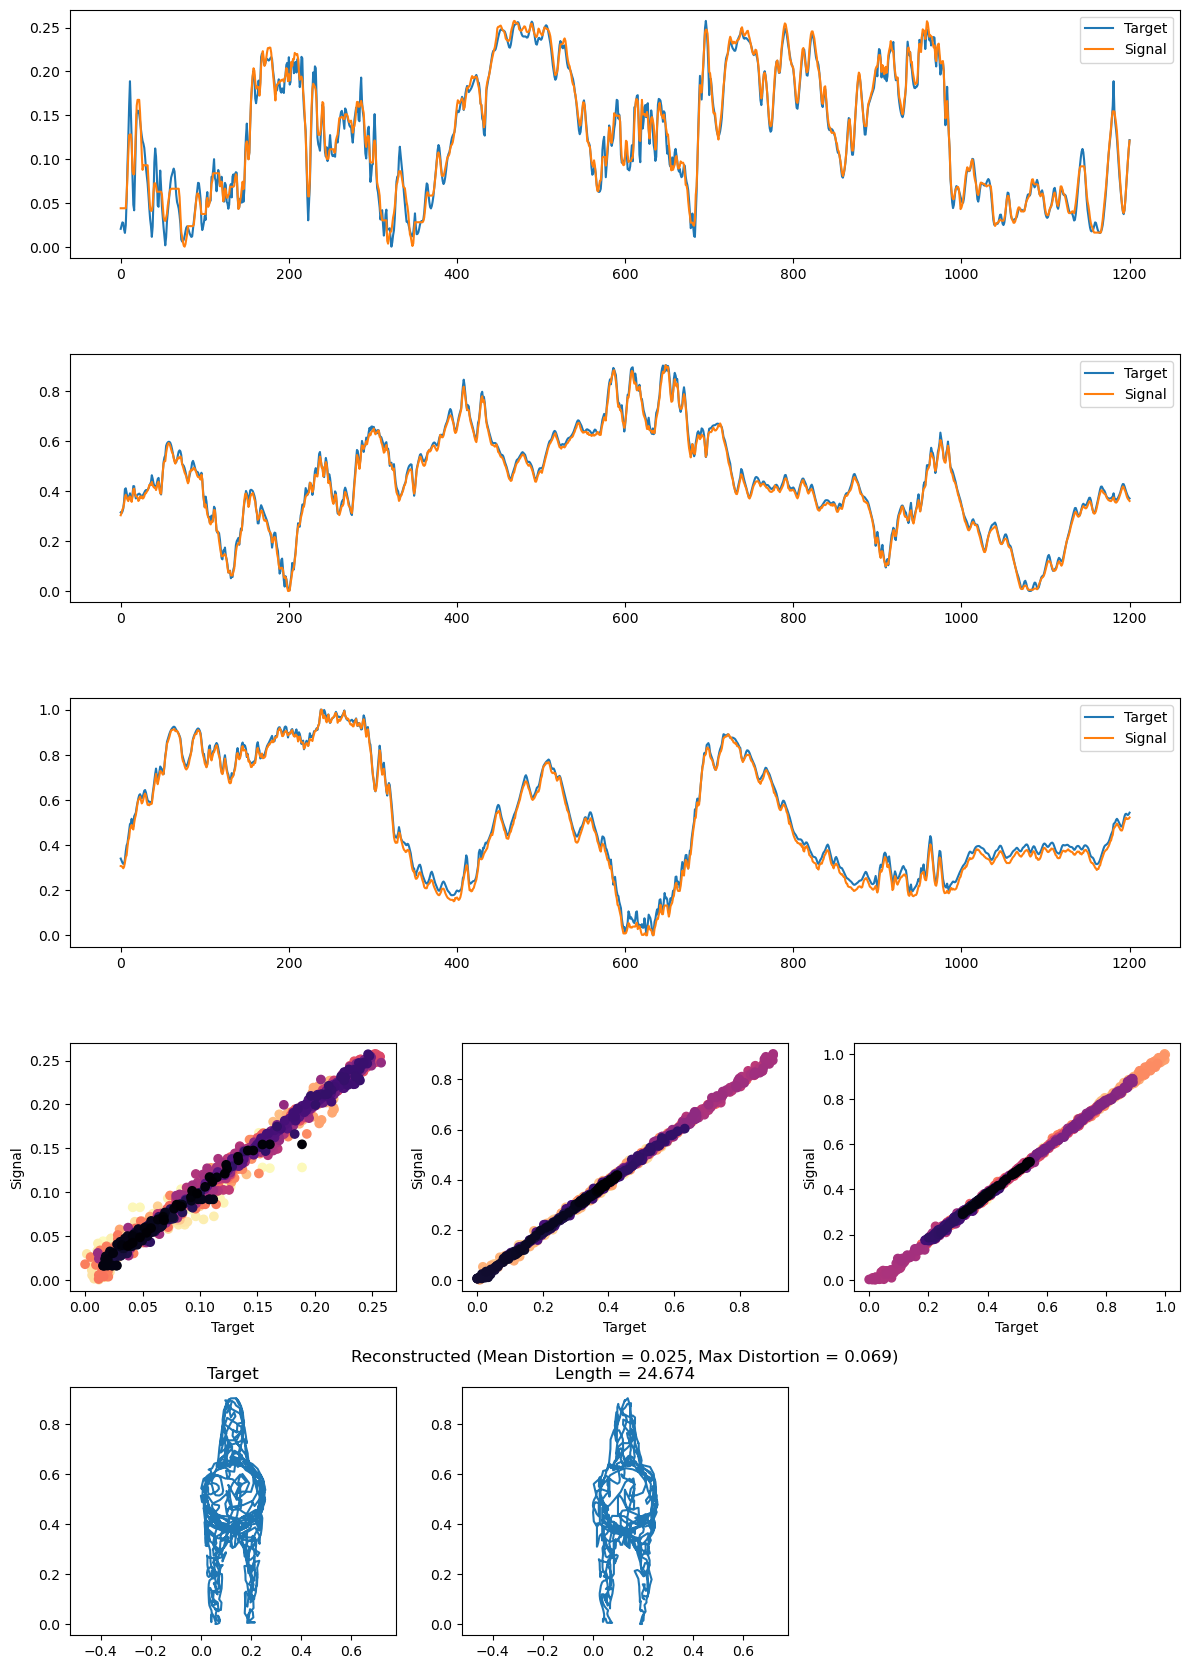

In [3]:
x, sr = librosa.load("../../data/tunes/wildhorses.mp3", sr=44100)
win_length = 1024
LT = 64

mag_idxs = [1, 2, 3]
print([int(fi*sr/win_length) for fi in mag_idxs])
phase_idxs = mag_idxs

# Sliding window parameters
win = 16
fit_lam = 0.5
q = -1

max_ratio = 0

sp = STFTPowerDisjoint(x, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, do_viterbi=True, LT=LT)
sp.plot(normalize=False)

sp.solve()
sp.plot(normalize=True)

In [4]:
y = sp.reconstruct_signal()
ipd.Audio(y, rate=sr)

x.size 1322944


Doing Gaps: win_length 1024, LT 64
viterbi_K =  3


<Figure size 600x600 with 0 Axes>

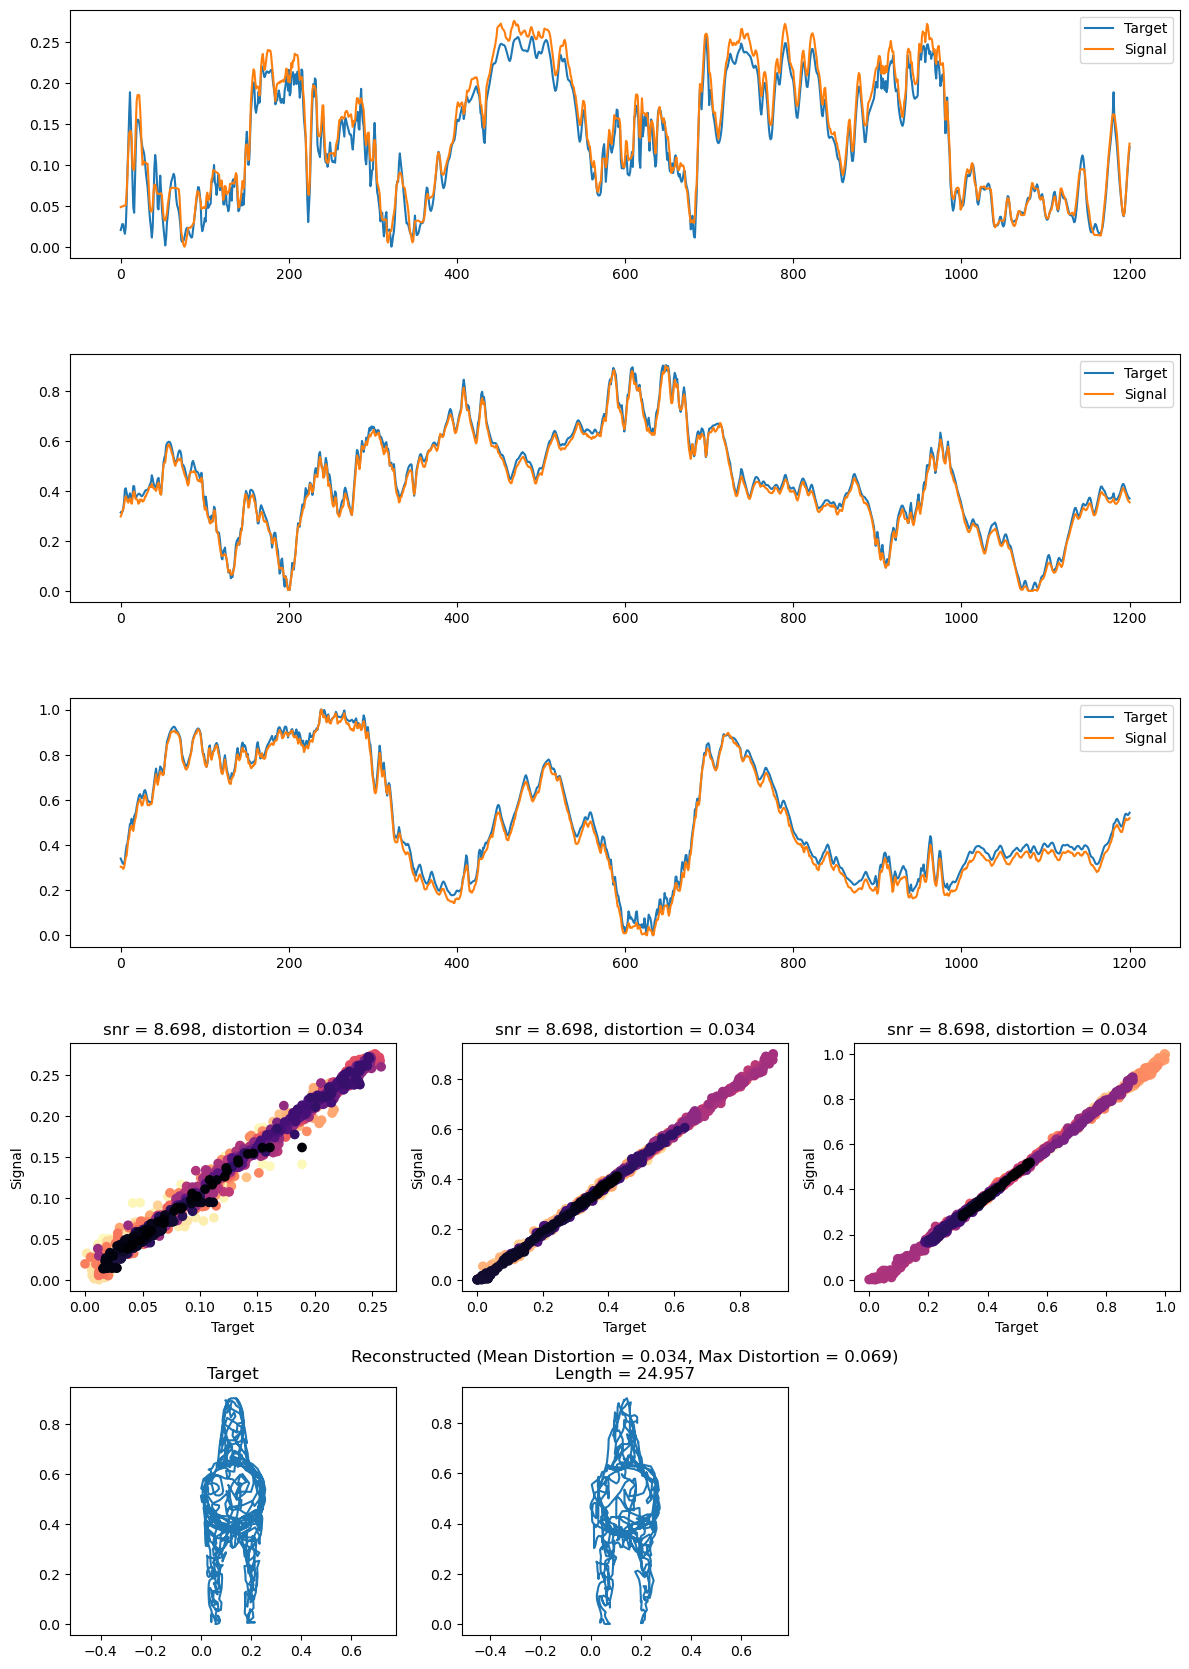

In [5]:
prefix = "rollingstones-horse-3d"
filename = "{}.mp3".format(prefix)
wavfile.write("out.wav", sr, y)
if os.path.exists(filename):
    os.remove(filename)
subprocess.call("ffmpeg -i out.wav".split() + [filename], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
os.remove("out.wav")

z, sr = librosa.load(filename, sr=sr)
z_sp = STFTPowerDisjoint(z, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, LT=LT)
z_sp.MagSolver.targets = [x for x in sp.MagSolver.targets]
snr = get_snr(x, z)
distortion = z_sp.get_distortion()[0]
ratio = snr/distortion

fhz = [fi*sr/win_length for fi in mag_idxs]
title = "snr = {:.3f}, distortion = {:.3f}".format(snr, distortion)

plt.figure(figsize=(6, 6))
z_sp.plot(True, title)
plt.tight_layout()
plt.savefig("{}.png".format(prefix), facecolor='white')
